# LoRa Data Analysis - Thompson Sampling


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Bandwidth: 125 kHz

End nodes:
- used a thompson sampling (TS) for communication parameters selection.

Access points:
- two access points were used to avoid a duty cycle depletion

Initial declaration

In [15]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

mpl_inl.backend_inline.set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
subfolder = 'data/s3r5'
uplink_message_file = './' + subfolder + '/uplink_messages.csv'
algorithm = 'ts'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [16]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [17]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,...,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id,dev_id,application_id,battery
0,83862,QjVCQkJCAA==,3.75,-111,33743,t,2023-09-27 13:43:23.081,20034,866900000,9,...,-689879779,4/7,125000,3336,1,333333,qqqq,83832,NaN,NaN
1,83863,QjVCQkJCAA==,11.75,-87,33382,t,2023-09-27 13:43:27.123,9423,866700000,8,...,-689876514,4/7,125000,2987,1,333333,3d3d,83833,NaN,NaN
2,83864,QjVCQkJCAA==,4.25,-106,33269,t,2023-09-27 13:43:28.654,39893,866700000,8,...,-689874015,4/7,125000,5201,1,333333,u7u7,83834,NaN,NaN
3,83865,QjVCQkJCAA==,8.75,-68,33156,t,2023-09-27 13:43:31.684,37806,866900000,7,...,-689870889,4/7,125000,3608,1,333333,VVVV,83835,NaN,NaN
4,83866,QjVCQkJCAA==,8.00,-97,33093,t,2023-09-27 13:43:33.217,20222,866500000,10,...,-689869626,4/7,125000,3245,1,333333,zMzM,83836,NaN,NaN


Let us have a look for different values to get an overview of overall values of different network parameters.

In [18]:
uplink_data.describe()

,id,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,bandwidth,msg_group_number,message_type_id,ap_id,dev_id,application_id,battery
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1.262000e+03,1262.000000,1262.0,1.262000e+03,1262.0,1262.000000,1262.0,1262.000000,1262.000000,0.0,0.0
mean,84492.500000,9.302496,-85.792393,9003.632330,31287.561014,8.665466e+08,8.528526,0.0,-6.877097e+08,125000.0,3693.282884,1.0,530902.797147,84462.500000,NaN,NaN
std,364.452329,2.848293,16.689676,11083.893745,17863.704967,2.805630e+05,1.005328,0.0,1.820154e+06,0.0,833.716554,0.0,220937.922747,364.452329,NaN,NaN
min,83862.000000,-12.000000,-118.000000,1.000000,110.000000,8.661000e+08,7.000000,0.0,-6.898798e+08,125000.0,2076.000000,1.0,333333.000000,83832.000000,NaN,NaN
25%,84177.250000,8.000000,-102.000000,29.000000,16663.000000,8.663000e+08,8.000000,0.0,-6.894334e+08,125000.0,3250.250000,1.0,333333.000000,84147.250000,NaN,NaN
50%,84492.500000,9.500000,-84.000000,1937.000000,34173.000000,8.665000e+08,8.000000,0.0,-6.891048e+08,125000.0,3423.500000,1.0,333333.000000,84462.500000,NaN,NaN
75%,84807.750000,11.500000,-71.000000,16717.500000,45838.750000,8.667000e+08,9.000000,0.0,-6.858319e+08,125000.0,4316.750000,1.0,777777.000000,84777.750000,NaN,NaN
max,85123.000000,20.750000,-52.000000,35908.000000,65316.000000,8.669000e+08,10.000000,0.0,-6.852932e+08,125000.0,5306.000000,1.0,777777.000000,85093.000000,NaN,NaN


### Payload Length

In [19]:
uplink_data['payload_len'] = uplink_data.app_data.apply(len)
uplink_data.payload_len.describe()

count    1262.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
Name: payload_len, dtype: float64

In [20]:
payload_len = round(statistics.mean(uplink_data.payload_len), 2)
print(f'Mean value of payload length is {payload_len}.')

Mean value of payload length is 12.


### Spreading Factor

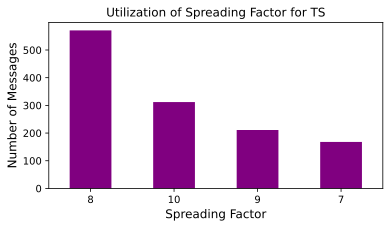

In [21]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='purple',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Spreading Factor for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-speading-factor.svg', dpi=300)
plt.show()

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [22]:
uplink_frequency = uplink_data.frequency / 1000000

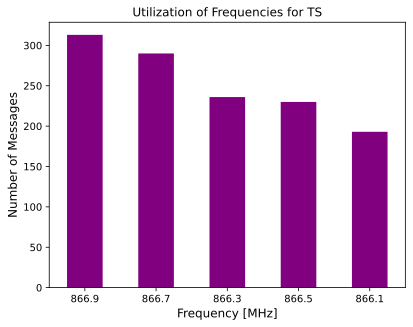

In [23]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='purple')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-frequencies.svg', dpi=300)
plt.show()

### Transmission Power

### Received Signal Strength Indicator

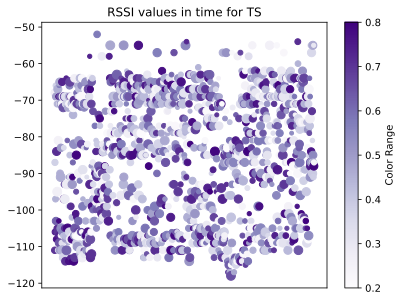

In [24]:
x = uplink_data.id
y = uplink_data.rssi
hist.set_xlabel('Time', fontsize=12)
#hist.set_ylabel('Number of Messages', fontsize=12)

# size and color:
sizes = np.random.uniform(15, 80, len(x))

# Define the colormap 'Purples' which is a gradient of purple
cmap = plt.get_cmap('Purples')

# Define vmin and vmax values to control the gradient
vmin = 0.2
vmax = 0.8

# Generate random values within the range [vmin, vmax]
normalized_values = (np.random.rand(len(x)) * (vmax - vmin)) + vmin

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=sizes, c=normalized_values, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar for reference
cbar = plt.colorbar(sc)
cbar.set_label('Color Range')

ax.set_xticks([])

plt.title(f'RSSI values in time for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-rssi.svg', dpi=300)
plt.show()

### Different Types of Messages

Let us analyze the ratio of message types.

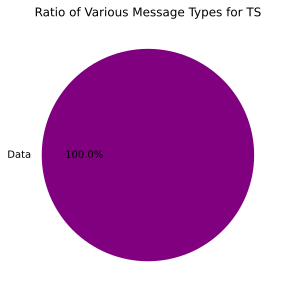

In [25]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Data'], colors=['purple', 'orange'])
plt.title(f'Ratio of Various Message Types for {algorithm.upper()}')

# Output is automatically exported
plt.savefig(f'./{subfolder}/{algorithm}-message-type.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [26]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 10.


In [27]:
uplink_data.node_id.describe()

count     1262
unique      10
top       qqqq
freq       211
Name: node_id, dtype: object

In [28]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 10
Total number of connected access points: 2


### Ratio of Message Transmission Attempts to Successful Message Deliveries (MTAMD)

Evaluation of MTAMD for end nodes.

In [258]:
end_nodes = uplink_data.groupby('node_id')

seq_tolerance = 15
first_seq = 0
last_seq = 0
prev_seq = 0
prev_node_id = ""
msg_count = 0
msg_delivered = 0
total_msg_count = 0

for name,group in end_nodes:
    for seq in group['seq']:
        if (abs(prev_seq - seq) > seq_tolerance):
            total_msg_count += prev_seq - first_seq
            msg_delivered += msg_count
            first_seq = seq
            msg_count = 0
        if prev_seq != seq:
            msg_count += 1
        prev_seq = seq
        prev_node_id = name
    if total_msg_count != 0:
        pdr = round(msg_delivered / total_msg_count * 100, 2)
        print(f'{name} reached MTAMD {pdr}%')
    first_seq = 0
    last_seq = 0
    prev_seq = 0
    msg_count = 0
    msg_delivered = 0
    total_msg_count = 0


3d3d reached MTAMD 53.76%
7u7u reached MTAMD 82.61%
VVVV reached MTAMD 75.0%
ZmZm reached MTAMD 57.28%
d3d3 reached MTAMD 77.27%
iIiI reached MTAMD 64.62%
mZmZ reached MTAMD 65.77%
qqqq reached MTAMD 59.69%
u7u7 reached MTAMD 69.4%
zMzM reached MTAMD 61.75%


The End.